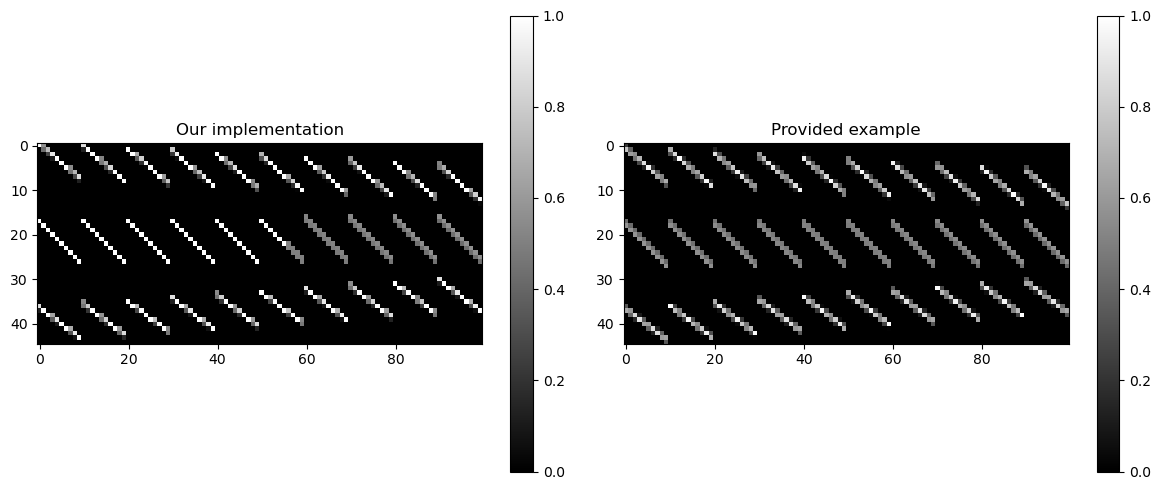

Maximum difference: 1.0
Mean difference: 0.07936980575323105
X_full shape: (49225, 38025)
y shape: (49225,)


In [11]:
#Exercise 1 WIP
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from zipfile import ZipFile

def read_npy_from_zip(zip_file, file_name):
    with ZipFile(zip_file, 'r') as zf:
        with zf.open(f"hs_tomography/{file_name}") as f:
            return np.load(f)

def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = 2*M

    D = M*M
    N = Np * len(alphas)

    y, x = np.mgrid[-M//2:M//2, -M//2:M//2]
    pixel_coords = np.vstack((x.ravel(), y.ravel()))

    row_indices = []
    col_indices = []
    values = []

    for idx, alpha in enumerate(alphas):
        theta = np.radians(alpha)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        
        rotated_coords = R @ pixel_coords
        proj = rotated_coords[0, :]

        sensor_indices = np.clip(np.floor(proj + Np//2).astype(int), 0, Np-2)
        
        dx = proj - (sensor_indices - Np//2 + 0.5)
        w1 = np.clip(1 - dx, 0, 1)
        w2 = np.clip(dx, 0, 1)

        pixel_indices = np.arange(D)
        row_indices.extend(idx*Np + sensor_indices)
        row_indices.extend(idx*Np + sensor_indices + 1)
        col_indices.extend(pixel_indices)
        col_indices.extend(pixel_indices)
        values.extend(w1)
        values.extend(w2)

    X = coo_matrix((values, (row_indices, col_indices)), shape=(N, D), dtype=np.float32)
    
    # Normalize X to [0, 1] range
    X_array = X.toarray()
    X_min, X_max = X_array.min(), X_array.max()
    X_normalized = (X_array - X_min) / (X_max - X_min)
    X = coo_matrix(X_normalized)
    
    return X

# Path to the zip file
zip_file_path = r'C:\Users\Anwender\MLE\MSE-Exercises\2024_06_26_Exercise_04\Exercise_04\Ex 04\hs_tomography.zip'

# Load the example data
X_example = read_npy_from_zip(zip_file_path, 'X_example.npy')

# Test the function with the same parameters as the example
M = 10
test_alphas = [-33, 1, 42]
X = construct_X(M, test_alphas, Np=15)

# Visualize our result and the provided example
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(X.toarray(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.title("Our implementation")
plt.colorbar()

plt.subplot(122)
plt.imshow(X_example, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.title("Provided example")
plt.colorbar()

plt.tight_layout()
plt.show()

# Compare the matrices
diff = np.abs(X.toarray() - X_example)
print(f"Maximum difference: {np.max(diff)}")
print(f"Mean difference: {np.mean(diff)}")

# Load the full problem data
alphas = read_npy_from_zip(zip_file_path, 'alphas_195.npy')
y = read_npy_from_zip(zip_file_path, 'y_195.npy')

# Construct X for the full problem
M = 195
Np = 275
X_full = construct_X(M, alphas, Np)

print("X_full shape:", X_full.shape)
print("y shape:", y.shape)

# Save X_full for later use 
np.save('X_full.npy', X_full.tocsr())